# Preconfiguring the IDE (Предварительная настройка среды разработки)

## Installing the required libraries (Установка необходимых библиотек)

Для локальной среды разработки:

In [ ]:
# !conda install -y -c conda-forge optuna
# !conda install -y -c conda-forge ipython-autotime
# !conda install -y -c plotly plotly
# !conda install -y -c conda-forge matplotlib
# !conda install -y -c anaconda scikit-image
# !conda install -y -c conda-forge keras
# !conda install -y -c conda-forge tensorflow
# !conda install -y -c conda-forge imageio

Solving environment: done

## Package Plan ##

  environment location: /home/artyom/miniconda3/envs/pytorch-1.13.0

  added / updated specs:
    - imageio


The following packages will be UPDATED:

  imageio            anaconda/linux-64::imageio-2.19.3-py3~ --> conda-forge/noarch::imageio-2.22.0-pyhfa7a67d_0 None


Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Retrieving notices: ...working... done
time: 35.8 s (started: 2022-11-15 15:26:22 +03:00)


Для Google Collab:

In [ ]:
!pip install optuna
!pip install ipython-autotime
!pip install plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 14.8 MB/s 
     |████████████████████████████████| 209 kB 61.0 MB/s 
     |████████████████████████████████| 81 kB 13.1 MB/s 
     |████████████████████████████████| 78 kB 10.1 MB/s 
     |████████████████████████████████| 50 kB 9.0 MB/s 
     |████████████████████████████████| 112 kB 59.2 MB/s 
     |████████████████████████████████| 147 kB 66.4 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=76627d3fb424fe090298f2fa656f4697e319feccaca7c92fd6fedf403e0c2e4e
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 14.4 MB/s 
Looking in indexes: https://pypi.org/simple, https

## Importing necessary libraries (Импорт необходимых библиотек)

In [ ]:
# Вспомогательные бибилотеки
import os
import time
import copy
import warnings
import multiprocessing
import gc


# Библиотеки, используемые для машинного обучения
from sklearn import metrics
from sklearn.metrics import classification_report
import numpy as np

# Библиотеки используемые для глубокого обучения
# Оптимизация гиперпараметров
import optuna

# Визуализация 
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_contour
from PIL import Image
from skimage import io
from tensorflow.keras.utils import img_to_array

import matplotlib.pyplot as plt
import matplotlib.image as mpimg


import torch

import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights
from torchvision.models import resnext50_32x4d, ResNeXt50_32X4D_Weights

ModuleNotFoundError: ignored

## Load dataset (Загрузка датасета)

Для Google Collab:

In [ ]:
# # Подключим диск Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# !unzip /content/drive/MyDrive/MIPT/Data_Scientist/Data_analysis_techniques_and_machine_learning_methods/Part_2/Homework_5/Data/Dataset.zip -d /content/

time: 226 µs (started: 2022-11-15 11:49:42 +03:00)


## Setting up the development environment (Настройка среды разработки)

In [ ]:
# Настройка среды разраотки

# Определим наличие графического ускорителя. Если доступен - используем.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Current Putorch device is set to", device)

# Количество рабочих процессов, зависи от CPU
system_num_workers = multiprocessing.cpu_count()
print("The number of workers processes is set at", system_num_workers)


# Настройка расширения ipython-autotime выводящего время выполнения ячейки.
%load_ext autotime

# Отключим вывод предупреждений FutureWarning 
warnings.simplefilter(action='ignore', category=FutureWarning)

# Для воспроизводимости результата зададим параметр генератора случайных чисел
torch.manual_seed(17)

# Размер батча (пачки) одновременно загружаемых в GPU изображений
batch_size=8

# Путь к датасету
data_dir = './data'

Current Putorch device is set to cuda:0
The number of workers processes is set at 16
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 2.04 ms (started: 2022-11-15 11:49:43 +03:00)


## Additional Functions (Дополнительные функции)

Для загруки предварительно обученной модели по ее имени будем использовать функцию *get_model*:

In [ ]:
def get_model(model_name: str = "resnet50", output_class_count = 3):
  
  model_name = model_name.lower()

  if model_name == "resnet50":
    
    model = models.resnet50(weights=ResNet50_Weights.DEFAULT, progress=True)
    
    # У этой нейронной сети слои имеют названия, последний слой назвается "fc".
    # Получим количество входных признаков для последнего полносвязного слоя
    in_features = model.fc.in_features

    # Отключаем обновление параметров для всех слоев
    for param in model.parameters():
      param.requires_grad = False

    # Заменим последний полносвязный слой на новый, с необходимым нам 
    # количеством выходов и возможностью обновлением параметров
    model.fc = nn.Linear(in_features, output_class_count)

  elif model_name == "mobilenet_v3_large":
    # У этой нейронной сети последним является блок слоев c названием "classifier".
    # В этом блоке именно последний слой отвечает за количество классов.
    # Внутри блока у слоев нет имен, тольько номера.
  
    model = models.mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT, progress=True)
    
    # Получим количество входных признаков для последнего полносвязного слоя
    in_features = model.classifier[3].in_features

    # Заменим последний полносвязный слой на новый, с необходимым нам 
    # количеством выходов и возможностью обновлением параметров
    for param in model.features.parameters():
      param.requires_grad = False


    # Заменим последний полносвязный слой на новый, с необходимым нам 
    # количеством выходов и возможностью обновлением параметров
    model.classifier[3] = nn.Linear(in_features, output_class_count)

  elif model_name == "resnext50_32x4d":
    # Аналогично "resnet50" слои имеют названия.

    model = torchvision.models.resnext50_32x4d(weights=ResNeXt50_32X4D_Weights.DEFAULT, progress=True)
    
    # Получим количество входных признаков для последнего полносвязного слоя
    in_features = model.fc.in_features
    
    # Заменим последний полносвязный слой на новый, с необходимым нам 
    # количеством выходов
    model.fc = nn.Linear(in_features, output_class_count)


  return model

time: 946 µs (started: 2022-11-15 11:49:45 +03:00)


Обучать и оценивать модель будем с помощью функции *train_model*:

In [ ]:
def train_model(trial, model, criterion, optimizer, num_epochs=5):
    
    # Запомним время начала обучения модели
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    
    # Создадим счётчик точности модели
    best_acc = 0.0

    # Итерируемся по эпохам
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Сначала обучаем модель, затем оцениваем (валидируем)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()           # Переводим модель в режим обучения
            else:
                model.eval()            # Переводим  модель в режим валидации (оценки качества)
            
            # Обнуляем счётчики для текущего цикла обучения/валидации 
            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                 # обнуляем градиент
                optimizer.zero_grad()
                
                # Если текущий цикл - цикл обучения, то включаем расчёт градиента
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()   # bаckpropagation (вычисление градиентов)
                        optimizer.step()  # обновление весов сети

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            # Расчитываем потери и accuracy текущей эпохи, и выводим их
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Если в процессе валидации получили модель качеством лучше, то сохраняем её в RAM
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
        
        trial.report(epoch_acc, epoch)
        
        # Если текущее исследование должно быть обрезку, то обрезаем его
        if trial.should_prune():
            raise optuna.TrialPruned()

    # Вычисляем время затраченное для обучения
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    
    # DEBUG
    print("FUNC train_model, model type :", type(model))
    
    return model, best_acc



time: 1.26 ms (started: 2022-11-15 11:49:46 +03:00)


Так как обьем видеопамяти небольшой (4 GB), необходимо очищать видеопамять после завершения каждого цикла обучения модели с помощью функции `clear_cuda_cache()`:

In [ ]:
def clear_cuda_cache():
    torch.cuda.empty_cache()
    gc.collect()

time: 271 µs (started: 2022-11-15 11:49:48 +03:00)


Получать прогноз от модели для валидационного датасета будем с помощью функции `predict`:

In [ ]:
def predict(model, loader):
    true_labels = []
    predicted_labels = []
    dataiter = iter(loader)
    with torch.no_grad():
        for batch in dataiter:
            x, y = batch
            true_labels += y.detach().cpu().numpy().tolist()
            x = x.to(device)
            y = y.to(device)
            pred = model(x)
            predicted_labels += np.argmax(pred.detach().cpu().numpy(), axis=1).tolist()
    return true_labels, predicted_labels

time: 447 µs (started: 2022-11-15 11:49:49 +03:00)


Функция для проверки работоспособности модели с помощью изображения из интернета:

In [ ]:
def url_image_label(model, url):
    image = io.imread(url)                    # Получим изображение из интернет
    PIL_image = Image.fromarray(image)        # Преобразуем изображение в PIL
    image = data_transforms['val'](PIL_image) # Трансформируем изображение, с помощью тех же трансформаций что использовались для валидационного набора изображений.
    image = torch.unsqueeze(image, 0)         # Добавим еще одно измерение
    pred = model(image.to(device))            # Получим предсказание модели
    PIL_image.show()
    print("Predicted label for picture: {}".format(class_names[np.argmax(pred.detach().cpu().numpy())]))
    
    
# print("Predicted label for picture: {}".format({class_names[np.argmax(pred.detach().cpu().numpy(), axis=1)]})) Не заработал, надо разбираться.

time: 588 µs (started: 2022-11-15 16:00:48 +03:00)


# Problem Definition (Описание проблемной области)

Необходимо реализовать систему классификации лиц животных. Задача представляет из себя классификацию на 3 класса.
1. Необходимо загрузить изображения и привести их к единому формату. Важно понимать, что исходное разрешение очень больше, и простые сети на несколько слоев могут выдать не такое хорошее качество.
2. Необходимо обучить нейросеть для распознавания 3 классов, желательно будет сравнить результаты на нескольких параметрах.
3. Оценить по метрикам качества для каждого класса.
***Важно визуализировать результат прогноза (на тесте) в человеко-читаемом формате с подписью.***

> На "ОТЛИЧНО"
> - Aугментация изображений.
> - Файнтюнинг крупной сверточной сети.

***Подсказки:***

- Как найти файлы в папках: https://pythoner.name/walk
- Как загрузить изображение по пути:
``` python
from PIL import Image
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
img = np.asarray(Image.open(path_to_image))
plt.imshow(img_to_array(img))
```

# Data augmentation (Аугментация данных)

In [ ]:
# Зададим последовательности преобразований изображений

data_transforms = {
    'train': transforms.Compose([                                           # Последовательность преобразований для тренировочной части
        transforms.Resize(224),                                             # Изменим размер изображения
        transforms.ToTensor(),                                              # Конвертируем изображение в тензор
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Номализуем изображение используем среднее и стандартное отклонение набора данных ImageNet в целом
    ]),
    'val': transforms.Compose([                                             # Последовательность преобразований для валидационной части  
        transforms.Resize(224),                                             # Изменим размер изображения
        transforms.ToTensor(),                                              # Конвертируем изображение в тензор
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Номализуем изображение используем среднее и стандартное отклонение набора данных ImageNet в целом
    ]),
}

# Создадим данных для датасета
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

# Создадим загрузчики данных
data_loaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=system_num_workers)
              for x in ['train', 'val']}

# Получим размеры датасетов
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# Получим имена классов
class_names = image_datasets['train'].classes

time: 184 ms (started: 2022-11-15 11:49:52 +03:00)


# Hyperparameter optimization with Optuna (Оптимизация гиперпараметров с помощью Optuna)

Оптимизация гиперпараметров - задача по поиску наиболее оптимальных гиперпараметров для обучаемого алгоритма.

Цель оптимизации гиперпараметров - получить наиболее оптимальные значения оптимизируемой метрики (в нашем случае метрики качества модели `accuracy`).

## Using Optuna (Использование Optuna)

### Creating the objective function (Создание целевой функции)

Для выполнения оптимизации гиперпараметров с помощью Optuna нам необходимо создать **целевую функцию (Objective Function)**. Целевая функция - это функция, которую необходимо оптимизировать. В нашем случае целью оптимизации является выбор модели нейронной сети и соответствующих гиперпараметров. В список оптимизруемых гиперпараметров входят:
1. три нейронные сети - "resnet50", "mobilenet_v3_large", "resnext50_32x4d",
2. скорость обучения этих нейронных сетей (два дискретных значения) - 0.0001, 0.0002,
3. один оптимизатор градиентного спуска используемый в процессе обучения нейронных сетей - AdamW.

Создадим нашу целевую функцию:

In [ ]:
def objective(trial):

    # Гиперпараметры, которые необходимо оптимизировать в рамках испытания "trial"
    params = {
        "model_name": trial.suggest_categorical('model_name',["resnet50", "mobilenet_v3_large", "resnext50_32x4d"]), # Список нейронных сетей (категориальный параметр испытаний)
        "learning_rate": trial.suggest_float('learning_rate', 0.0001, 0.0002, step=0.0001),                          # Скорость обучения (дискретный параметр)
        "optimizer_name": trial.suggest_categorical('optimizer_name',["AdamW"])                                      # Оптимизаторы градиентного спуска
    }
    
    # Получение предварительно обученной модели
    model = get_model(params["model_name"])
    model = model.to(device)
    
    # Определим критерий оптимизации используемый для вычисления потерь между входными и целевыми значениями. 
    # Иными словами функция потерь, используемая в оптимизируемых нейронных сетях.
    # Используем кроссэнтропию, так как классификация многоклассовая
    criterion = nn.CrossEntropyLoss()
    
    # Настроим оптимизатор
    optimizer = getattr(
        torch.optim, 
        params["optimizer_name"])(model.parameters(), lr=params["learning_rate"])
    
    # Обучение модели
    best_model, best_acc = train_model(trial, model, criterion, optimizer, num_epochs=3)
    
    # Возвращает точность (целевое значение) текущего испытания
    return best_acc

time: 722 µs (started: 2022-11-15 11:49:55 +03:00)


## Approaches used to optimize hyperparameters (Подходы используемые для оптимизации гиперпараметров)

В своей работе я рассмотрю три подхода для оптимизации гиперпараметров:    
- поиск по решетке (Grid search),    
- случайный поиск (Random search),    
- оценщик Парзена с древовидной структурой (Tree-structured Parzen Estimator).  

> ПРИМЕЧАНИЕ:
> В рамках проверки методов случайного поиска и оценщика Парзена с древовидной структурой необходимо установить ограничение на максимальное количество испытаний (`n_trials`) равное количеству всех возможных комбинаций гиперпараметров:
> Будем проверять:
> 1. Три различные нейронные сети - "resnet50", "mobilenet_v3_large", "resnext50_32x4d". Из которых можно выбрать только одну - $C_{3}^{1} = 3$
> 2. Две различные скорости обучения - 0.0001, 0.0002. Из которых можно выбрать только одну - $C_{2}^{1} = 2$
> 3. Один оптимизатор градиентного спуска - "AdamW". Его можно выбрать всего одним способом - $C_{1}^{1} = 1$    
> 
> Тогда общее количество возможных комбинаций параметров для всех моделей:    
> $C^{1}_{3} \cdot C^{1}_{1} \cdot C^{1}_{1} = \frac{3!}{2!} \cdot \frac{2!}{2!} \cdot \frac{1!}{1!} = 3 \cdot 2 \cdot 1 = 6$
>
> Направление оптимизации метрики задается параметром `direction`. В нашем случае мы будем максимизировать значение целевой функции `direction='maximize'` (чему выше `accuracy`, тем лучше).

### Grid search (поиск по решётке)

Поиск по решётке - традиционный метод оптимизации гиперпарамеров который заключается в полном переборе всех комбинаций гиперпараметров по заданному подмножеству пространства гиперпараметров обучаемого алгоритма.

***ДОСТОИНСТРА:***
1. Простота реализации алгоритма
2. Легкая параллелизация, поскольку обычно гиперпараметрические величины, с которыми алгоритм работает, не зависят друг от друга

***НЕДОСТАТКИ:***
1. Страдает от проклятия размерности.
2. Большая длительность перебора в виду необходимости проверки всех возможных комбинаций.

> ***ПРИМЕЧАНИЕ: Реализация данного метода в библиотеке Optuna не гарантирует что перебор гиперпараметров будет идти упорядоченно!***    
> ***Процесс оптимизации гиперпараметров остановиться автоматический когда будут выбраны все возможные комбинации гиперпараметров. Его нет смысла ограничивать максимальным ноличеством испытаний.***



In [ ]:
# Определяем сетку гиперпараметров для GridSampler
hyperparameter_grid = {"model_name": ["resnet50", "mobilenet_v3_large", "resnext50_32x4d"],
                       "learning_rate": [0.0001, 0.0002],
                       "optimizer_name": ["AdamW"]}

# Создаем исследование (study)
study = optuna.create_study(sampler=optuna.samplers.GridSampler(hyperparameter_grid), direction='maximize')

# Запускаем процесс исследования (оптимизации гиперпараметров)
study.optimize(objective)

# Выводим номер наиболее оптимального испытания и его гиперпараметры
print("Best trial number: ", study.best_trial.number)
print("Best params:", study.best_trial.params)

[I 2022-11-13 18:30:05,295] A new study created in memory with name: no-name-eca08a3a-a71e-4e7a-ada2-59f474e351d4


Epoch 0/2
----------
train Loss: 0.0612 Acc: 0.9819
val Loss: 0.0199 Acc: 0.9947

Epoch 1/2
----------
train Loss: 0.0222 Acc: 0.9936
val Loss: 0.0426 Acc: 0.9840

Epoch 2/2
----------
train Loss: 0.0146 Acc: 0.9953


[I 2022-11-13 18:44:59,763] Trial 0 finished with value: 0.9946666666666666 and parameters: {'model_name': 'resnext50_32x4d', 'learning_rate': 0.0002, 'optimizer_name': 'AdamW'}. Best is trial 0 with value: 0.9946666666666666.


val Loss: 0.2757 Acc: 0.9913

Training complete in 14m 54s
Best val Acc: 0.994667
Epoch 0/2
----------
train Loss: 0.2659 Acc: 0.9458
val Loss: 0.0778 Acc: 0.9920

Epoch 1/2
----------
train Loss: 0.0982 Acc: 0.9736
val Loss: 0.0434 Acc: 0.9947

Epoch 2/2
----------
train Loss: 0.0735 Acc: 0.9796


[I 2022-11-13 18:48:40,886] Trial 1 finished with value: 0.9953333333333333 and parameters: {'model_name': 'resnet50', 'learning_rate': 0.0002, 'optimizer_name': 'AdamW'}. Best is trial 1 with value: 0.9953333333333333.


val Loss: 0.0307 Acc: 0.9953

Training complete in 3m 41s
Best val Acc: 0.995333
Epoch 0/2
----------
train Loss: 0.0616 Acc: 0.9825
val Loss: 0.0172 Acc: 0.9967

Epoch 1/2
----------
train Loss: 0.0161 Acc: 0.9955
val Loss: 0.0158 Acc: 0.9960

Epoch 2/2
----------
train Loss: 0.0104 Acc: 0.9971


[I 2022-11-13 19:05:57,716] Trial 2 finished with value: 0.9966666666666666 and parameters: {'model_name': 'resnext50_32x4d', 'learning_rate': 0.0001, 'optimizer_name': 'AdamW'}. Best is trial 2 with value: 0.9966666666666666.


val Loss: 0.0146 Acc: 0.9940

Training complete in 17m 17s
Best val Acc: 0.996667
Epoch 0/2
----------
train Loss: 0.1673 Acc: 0.9470
val Loss: 0.0399 Acc: 0.9860

Epoch 1/2
----------
train Loss: 0.0889 Acc: 0.9685
val Loss: 0.0267 Acc: 0.9933

Epoch 2/2
----------
train Loss: 0.0737 Acc: 0.9738


[I 2022-11-13 19:08:18,001] Trial 3 finished with value: 0.9933333333333333 and parameters: {'model_name': 'mobilenet_v3_large', 'learning_rate': 0.0001, 'optimizer_name': 'AdamW'}. Best is trial 2 with value: 0.9966666666666666.


val Loss: 0.0298 Acc: 0.9913

Training complete in 2m 20s
Best val Acc: 0.993333
Epoch 0/2
----------
train Loss: 0.1414 Acc: 0.9513
val Loss: 0.0331 Acc: 0.9907

Epoch 1/2
----------
train Loss: 0.0810 Acc: 0.9697
val Loss: 0.0273 Acc: 0.9927

Epoch 2/2
----------
train Loss: 0.0677 Acc: 0.9770


[I 2022-11-13 19:10:36,053] Trial 4 finished with value: 0.9926666666666666 and parameters: {'model_name': 'mobilenet_v3_large', 'learning_rate': 0.0002, 'optimizer_name': 'AdamW'}. Best is trial 2 with value: 0.9966666666666666.


val Loss: 0.0244 Acc: 0.9913

Training complete in 2m 18s
Best val Acc: 0.992667
Epoch 0/2
----------
train Loss: 0.3657 Acc: 0.9323


[I 2022-11-13 19:11:41,284] Trial 5 pruned. 


val Loss: 0.1412 Acc: 0.9907

Best trial number:  2
Best params: {'model_name': 'resnext50_32x4d', 'learning_rate': 0.0001, 'optimizer_name': 'AdamW'}
time: 41min 35s (started: 2022-11-13 18:30:05 +03:00)


#### Visualization of hyperparameter optimization history (Визуализация истории оптимизации гиперпараметров)

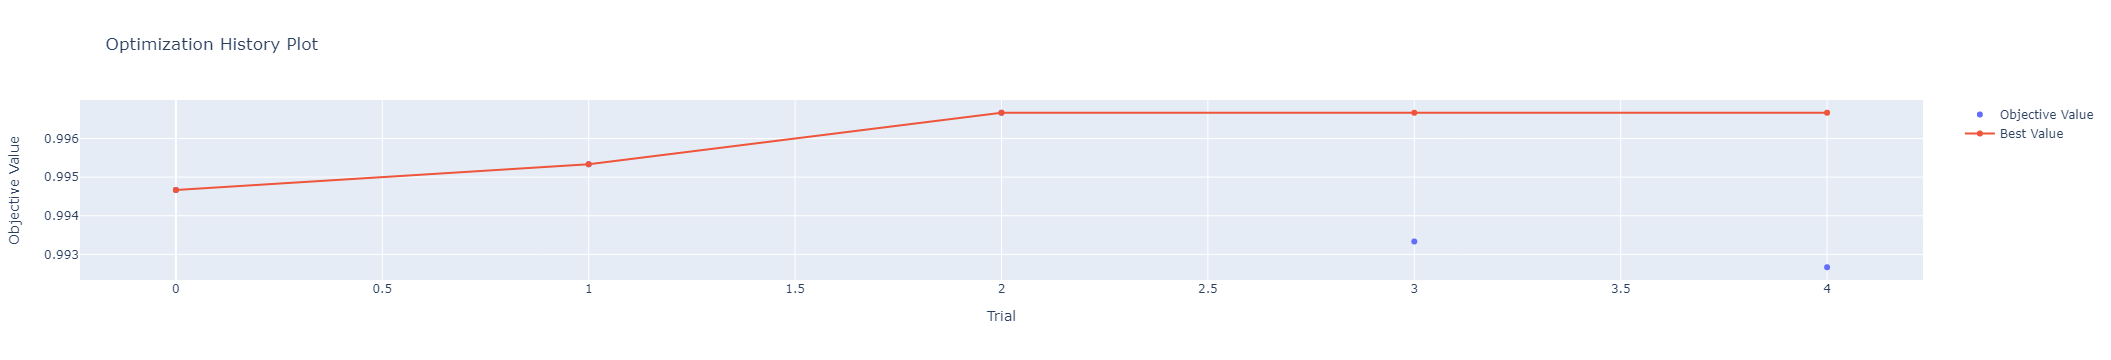

time: 23.4 ms (started: 2022-11-13 19:30:06 +03:00)


In [ ]:
plot_optimization_history(study)

#### Visualization of high-dimensional hyperparameter relations (Визуализация высокоразмерных отношений гиперпараметров)

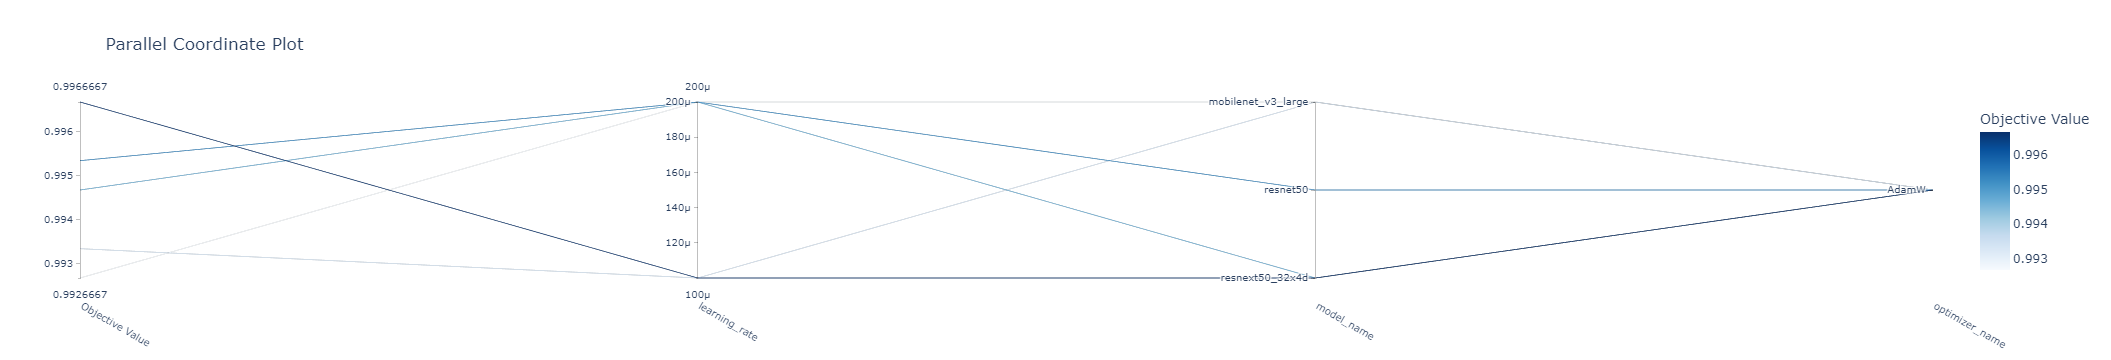

time: 5.98 ms (started: 2022-11-13 19:30:32 +03:00)


In [ ]:
plot_parallel_coordinate(study, params=["model_name", "learning_rate", "optimizer_name"])

#### Visualize the learning curves (Визуализация кривых обучения в ходе испытаний)

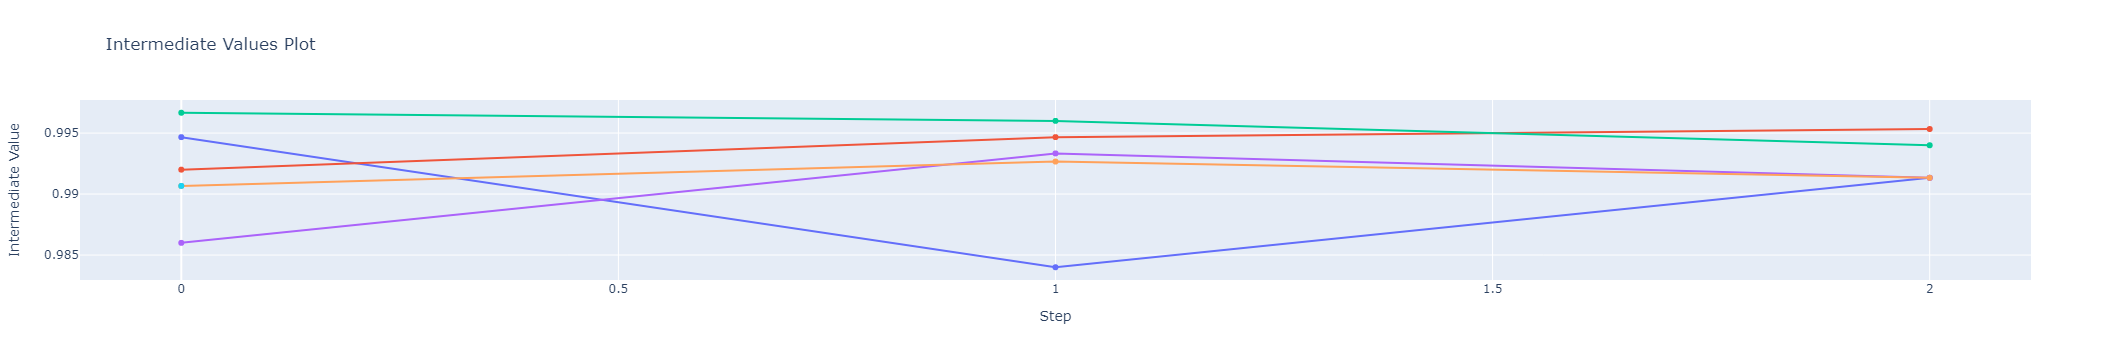

time: 9.32 ms (started: 2022-11-13 19:31:07 +03:00)


In [ ]:
plot_intermediate_values(study)

#### Visualize hyperparameter relationships (Визуализация взаимосвязей гиперпараметров)

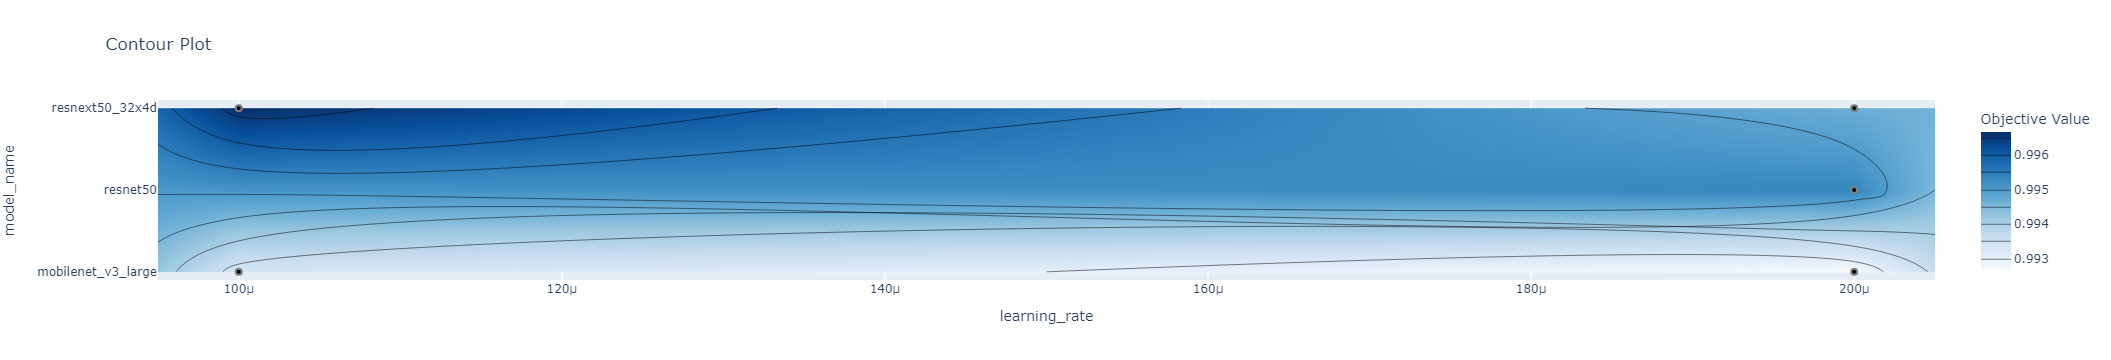

time: 9.02 ms (started: 2022-11-13 19:39:07 +03:00)


In [ ]:
plot_contour(study, params=["model_name", "learning_rate"])

#### Визуализация важности гиперпараметров

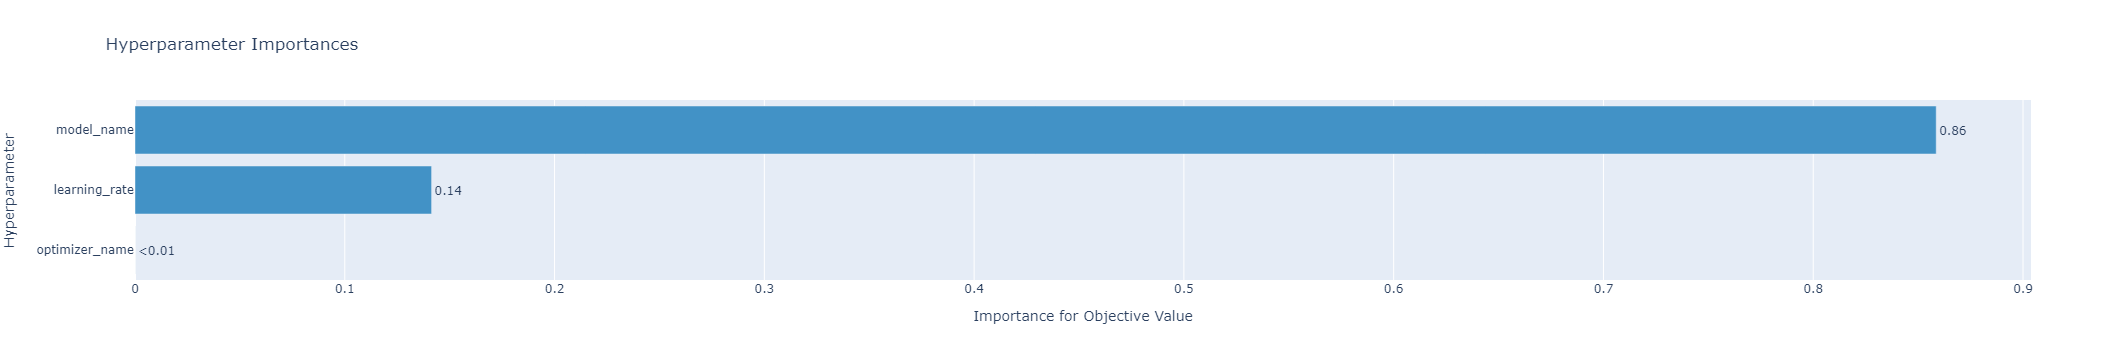

time: 84.4 ms (started: 2022-11-13 19:37:36 +03:00)


In [ ]:
plot_param_importances(study)

Очистим память видеоадаптера:

In [ ]:
clear_cuda_cache()

time: 276 ms (started: 2022-11-15 13:19:08 +03:00)


#### Intermediate result (Промежуточный итог)

За 6 испытаний были проверены все возможные комбинации гиперпараметров. При использовании алгоритма поиска по решетке, обычно, сначала проводят приблизительный поиск области пространства гиперпараметров содержащей наиболее оптимальные значения. 
Далее, определившись с данной областью выполняется уже более тщательный поиск с меньшим количеством комбинаций и более высокой дискретизацией.

### Random search (Случайный поиск)

Случайный поиск - метод заменяет полный перебор всех комбинаций на выборку их случайным образом.

***ДОСТОИНСТРА:***
1. Простота, 
2. Устойчивость,
3. Интуитивная понятность.

***НЕДОСТАТКИ:***
1. Низкая скорость сходимости, 
2. Неопределенность в выборе условий остановки. 

Кроме того, необходимо ограничение данного алгоритма, иначе процесс оптимизации будет бесконечным. Но! Нет никаких гарантий что наиболее оптимальные гиперпараметры будут найденны до момента окончания оптимизации.

Ограничим работу данного алгоритма оптимизации максимальным количеством испытаний равным 6 (`n_trials=6`). Кроме того, будем использовать обрезку (`MedianPruner`) испытаний с низким значением `accuracy` с использованием медианного правила остановки. Такие испытания будут отсеиваться, если лучший промежуточный результат текущего испытания хуже, чем медиана промежуточных результатов предыдущих испытаний. Обрезка испытаний отключается до тех пор, пока не закончится 3 полных испытания в рамках одном исследования (`n_startup_trials=3`).

> ***ПРИМЕЧАНИЕ:***    
> ***1. Кроме того, необходимо отключить обрезку в рамках одного испытания (Trial) до достижения как минимум половины от числа шагов (steps). Иначе всё испытание будет отбрасываться если в первой эпоху (шаг) будет получен результат меньше чем медиана промежуточных результатов предыдущих испытаний. То есть если в рамках первой эпохи обучения самой оптимальной комбинации гиперпараметров будет получен результат хуже (чем медиана промежуточных результатов предыдущих испытаний), то все испытание оптимальной комбинации гиперпараметров будет отброшенно. Лучше всего установить `n_warmup_steps` равный половине количества эпох заданных для обучения модели округленное в большую сторону. Например, если каждая модель обучается 3 эпохи, то $n\_warmup\_steps = (3 / 2 ) \approx 2$***.

In [ ]:
# Определим алгоритм выборки гиперпараметров по методу случайного поиска (семплер). 
sampler = optuna.samplers.RandomSampler()    

# Создаем исследование (study), настроим обрезку "плохих" испытаний.
study = optuna.create_study(
    sampler=sampler,
    pruner=optuna.pruners.MedianPruner(n_startup_trials=3, n_warmup_steps=2), direction='maximize')

# Запускаем процесс исследования (оптимизации гиперпараметров)
study.optimize(func=objective, n_trials=6)

# Выводим номер наиболее оптимального испытания и его гиперпараметры
print("Best trial number: ", study.best_trial.number)
print("Best params:", study.best_trial.params)

[I 2022-11-15 13:19:14,464] A new study created in memory with name: no-name-749c1eb8-1738-482e-a7f4-5fc015c8ced2


Epoch 0/2
----------
train Loss: 0.3691 Acc: 0.9336
val Loss: 0.1478 Acc: 0.9913

Epoch 1/2
----------
train Loss: 0.1410 Acc: 0.9690
val Loss: 0.0783 Acc: 0.9900

Epoch 2/2
----------
train Loss: 0.1057 Acc: 0.9720


[I 2022-11-15 13:22:29,665] Trial 0 finished with value: 0.992 and parameters: {'model_name': 'resnet50', 'learning_rate': 0.0001, 'optimizer_name': 'AdamW'}. Best is trial 0 with value: 0.992.


val Loss: 0.0569 Acc: 0.9920

Training complete in 3m 15s
Best val Acc: 0.992000
FUNC train_model, model type : <class 'torchvision.models.resnet.ResNet'>
Epoch 0/2
----------
train Loss: 0.0596 Acc: 0.9840
val Loss: 0.0176 Acc: 0.9947

Epoch 1/2
----------
train Loss: 0.0148 Acc: 0.9962
val Loss: 0.0492 Acc: 0.9880

Epoch 2/2
----------
train Loss: 0.0104 Acc: 0.9969


[I 2022-11-15 13:36:59,051] Trial 1 finished with value: 0.9966666666666666 and parameters: {'model_name': 'resnext50_32x4d', 'learning_rate': 0.0001, 'optimizer_name': 'AdamW'}. Best is trial 1 with value: 0.9966666666666666.


val Loss: 0.0190 Acc: 0.9967

Training complete in 14m 29s
Best val Acc: 0.996667
FUNC train_model, model type : <class 'torchvision.models.resnet.ResNet'>
Epoch 0/2
----------
train Loss: 0.1424 Acc: 0.9520
val Loss: 0.0289 Acc: 0.9927

Epoch 1/2
----------
train Loss: 0.0848 Acc: 0.9703
val Loss: 0.0253 Acc: 0.9933

Epoch 2/2
----------
train Loss: 0.0689 Acc: 0.9751


[I 2022-11-15 13:38:53,351] Trial 2 finished with value: 0.9933333333333333 and parameters: {'model_name': 'mobilenet_v3_large', 'learning_rate': 0.0002, 'optimizer_name': 'AdamW'}. Best is trial 1 with value: 0.9966666666666666.


val Loss: 0.0190 Acc: 0.9927

Training complete in 1m 54s
Best val Acc: 0.993333
FUNC train_model, model type : <class 'torchvision.models.mobilenetv3.MobileNetV3'>
Epoch 0/2
----------
train Loss: 0.0596 Acc: 0.9826
val Loss: 0.1315 Acc: 0.9887

Epoch 1/2
----------
train Loss: 0.0264 Acc: 0.9928
val Loss: 0.0104 Acc: 0.9953

Epoch 2/2
----------
train Loss: 0.0171 Acc: 0.9950


[I 2022-11-15 13:53:23,975] Trial 3 finished with value: 0.996 and parameters: {'model_name': 'resnext50_32x4d', 'learning_rate': 0.0002, 'optimizer_name': 'AdamW'}. Best is trial 1 with value: 0.9966666666666666.


val Loss: 0.0182 Acc: 0.9960

Training complete in 14m 30s
Best val Acc: 0.996000
FUNC train_model, model type : <class 'torchvision.models.resnet.ResNet'>
Epoch 0/2
----------
train Loss: 0.1591 Acc: 0.9492
val Loss: 0.0387 Acc: 0.9900

Epoch 1/2
----------
train Loss: 0.0941 Acc: 0.9664
val Loss: 0.0282 Acc: 0.9907

Epoch 2/2
----------
train Loss: 0.0730 Acc: 0.9738


[I 2022-11-15 13:55:28,012] Trial 4 pruned. 


val Loss: 0.0266 Acc: 0.9933

Epoch 0/2
----------
train Loss: 0.3661 Acc: 0.9316
val Loss: 0.1450 Acc: 0.9893

Epoch 1/2
----------
train Loss: 0.1421 Acc: 0.9678
val Loss: 0.0754 Acc: 0.9927

Epoch 2/2
----------
train Loss: 0.0998 Acc: 0.9750


[I 2022-11-15 13:58:42,881] Trial 5 pruned. 


val Loss: 0.0587 Acc: 0.9927

Best trial number:  1
Best params: {'model_name': 'resnext50_32x4d', 'learning_rate': 0.0001, 'optimizer_name': 'AdamW'}
time: 39min 28s (started: 2022-11-15 13:19:14 +03:00)


#### Visualization of hyperparameter optimization history (Визуализация истории оптимизации гиперпараметров)

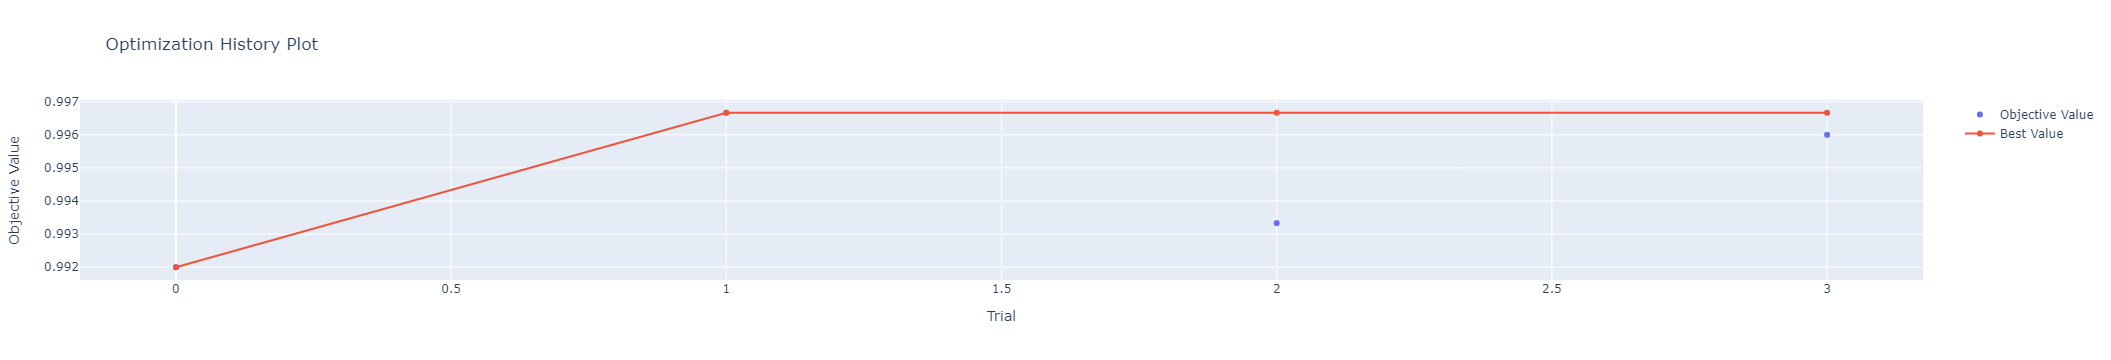

time: 8.79 ms (started: 2022-11-15 14:04:51 +03:00)


In [ ]:
plot_optimization_history(study)

#### Visualization of high-dimensional hyperparameter relations (Визуализация высокоразмерных отношений гиперпараметров)

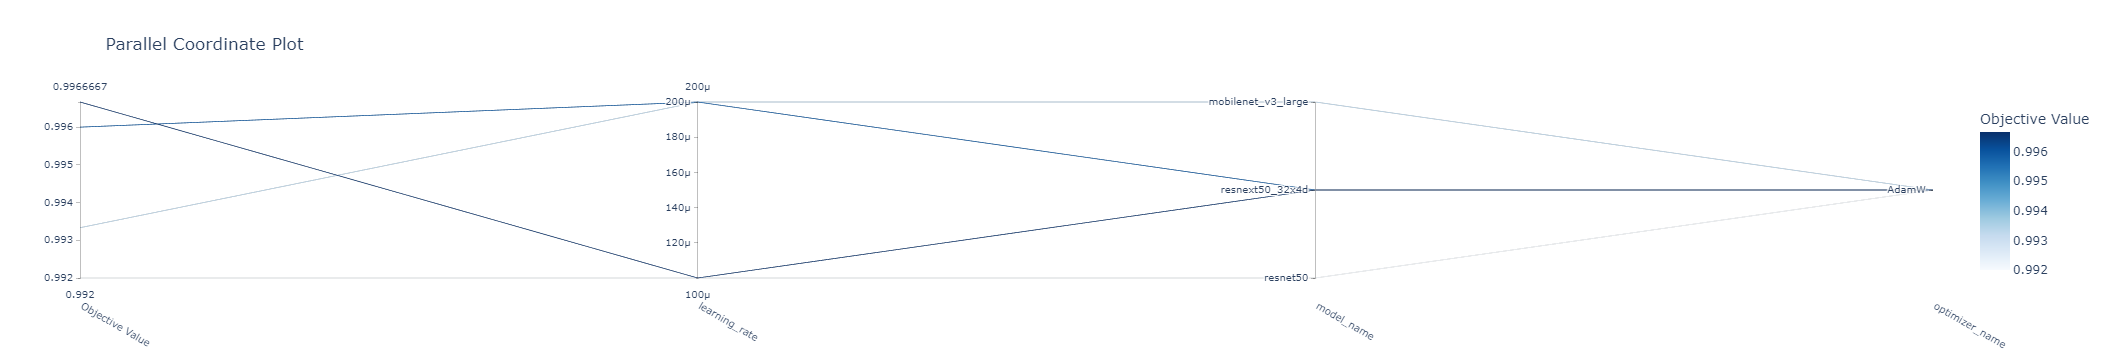

time: 6.75 ms (started: 2022-11-15 14:04:57 +03:00)


In [ ]:
plot_parallel_coordinate(study, params=["model_name", "learning_rate", "optimizer_name"])

#### Visualize the learning curves (Визуализация кривых обучения в ходе испытаний)

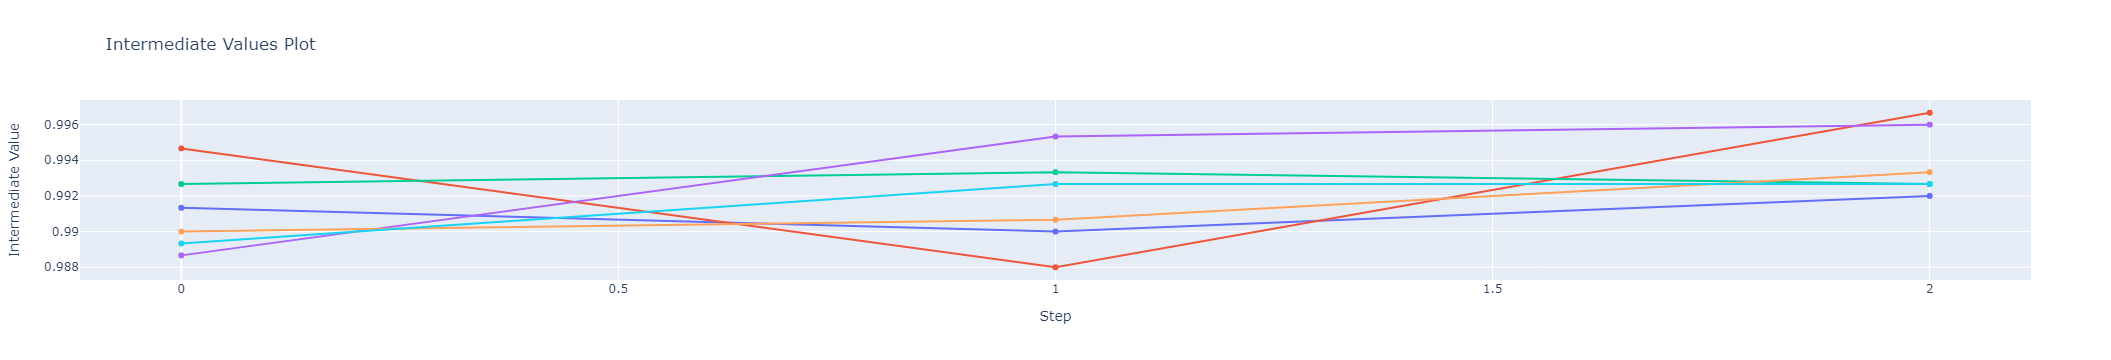

time: 5.9 ms (started: 2022-11-15 14:05:11 +03:00)


In [ ]:
plot_intermediate_values(study)

#### Visualize hyperparameter relationships (Визуализация взаимосвязей гиперпараметров)

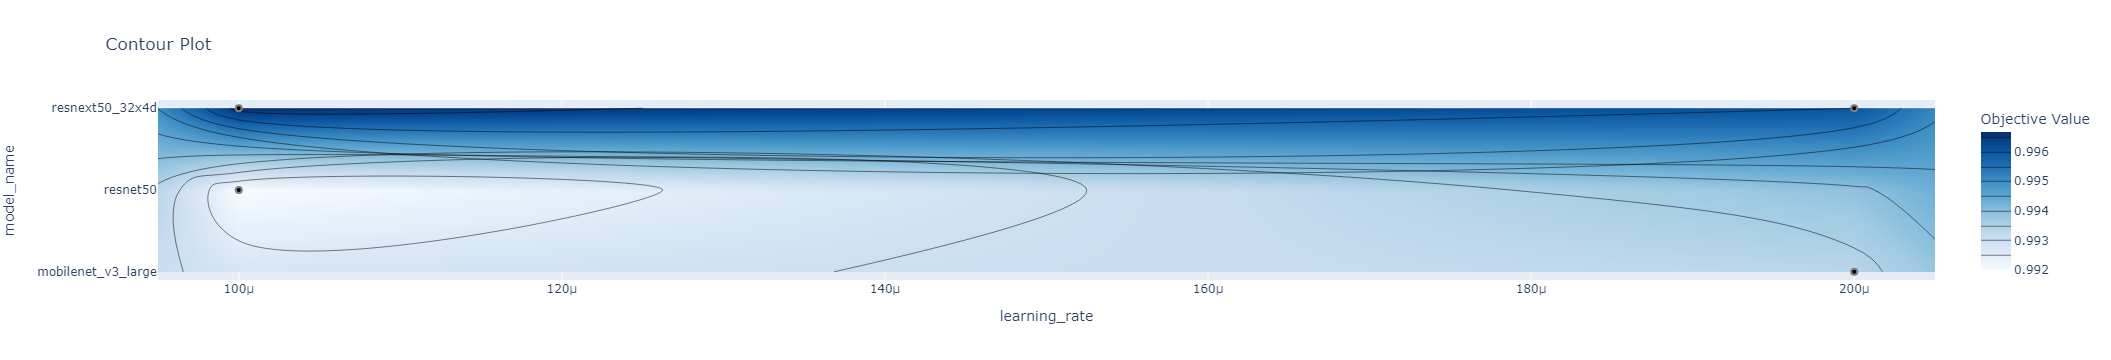

time: 11 ms (started: 2022-11-15 14:05:14 +03:00)


In [ ]:
plot_contour(study, params=["model_name", "learning_rate"])

#### Визуализация важности гиперпараметров

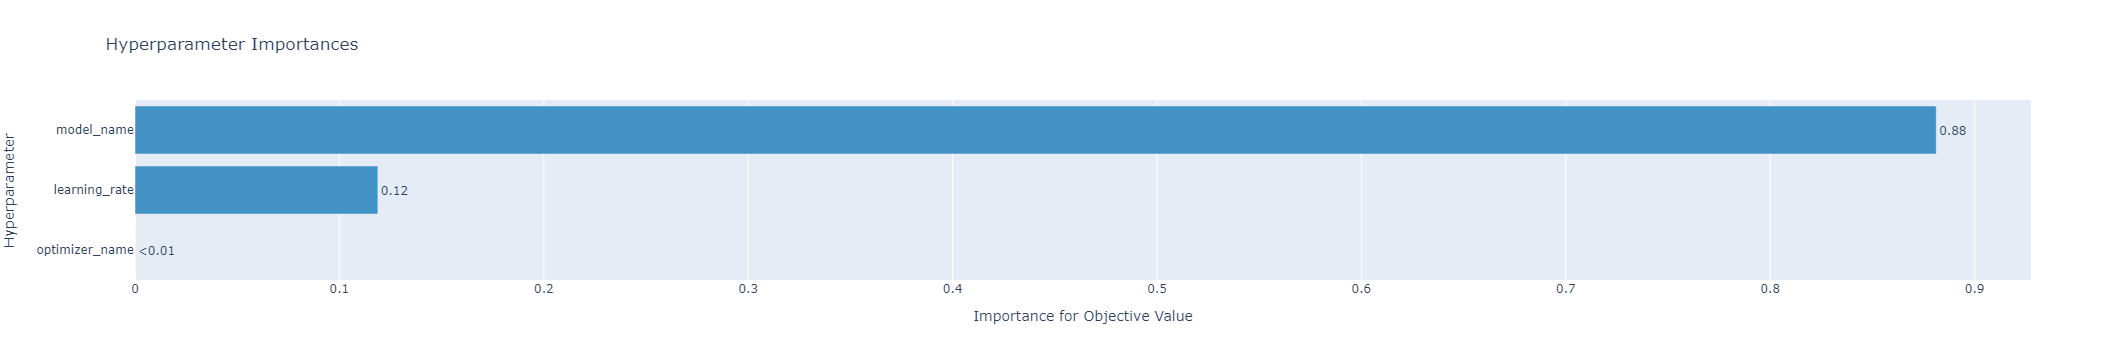

time: 72.4 ms (started: 2022-11-15 14:05:21 +03:00)


In [ ]:
plot_param_importances(study)

Очистим память GPU:

In [ ]:
clear_cuda_cache()

time: 262 ms (started: 2022-11-15 14:05:25 +03:00)


#### Intermediate result (Промежуточный итог)

В этот раз, в процессе случайного поиска *нам повезло*. Оптимальная комбинация гиперпараметров подобранная с помощью алгоритма поиска по решетке (`{'model_name': 'resnext50_32x4d', 'learning_rate': 0.0001, 'optimizer_name': 'AdamW'}`) была найдена в втором испытании. 
Но так может быть не всегда. Причина этого заключается в том, что при использовании алгоритма случайного поиска есть ненулевая вероятность что оптимальное значение гиперпараметров вообще не будет проверено за ограниченное количество испытаний.

### Tree-structured Parzen Estimator (Оценщик Парзена с древовидной структурой)

Оценщик Парзена с древовидной структурой - метод перебора параметров основанный на непараметрической оценке Панзера.  Широко используется для решения дорогостоящих одноцелевых задач оптимизации.

Достоинства:
- использует историю оцененных гиперпараметров для создания вероятностной модели, которая используется для предложения следующего набора гиперпараметров для оценки.

> ***ПРИМЕЧАНИЕ:*** 
> ***Настройки обрезчика аналогичны настройкам из пункта "Случайный поиск".***

In [ ]:
sampler = optuna.samplers.TPESampler()    

# Создаем исследование (study), настроим обрезку "плохих" испытаний.
study = optuna.create_study(
    sampler=sampler,
    pruner=optuna.pruners.MedianPruner(n_startup_trials=3, n_warmup_steps = 2), direction='maximize')

# Запускаем процесс исследования (оптимизации гиперпараметров)
study.optimize(func=objective, n_trials=6)

# Выводим номер наиболее оптимального испытания и его гиперпараметры
print("Best trial number: ", study.best_trial.number)
print("Best params:", study.best_trial.params)

[I 2022-11-15 14:07:33,388] A new study created in memory with name: no-name-dd75b3f1-9161-4546-bcbc-61cf4896a4cc


Epoch 0/2
----------
train Loss: 0.0600 Acc: 0.9840
val Loss: 0.0327 Acc: 0.9933

Epoch 1/2
----------
train Loss: 0.0113 Acc: 0.9971
val Loss: 0.0215 Acc: 0.9967

Epoch 2/2
----------
train Loss: 0.0125 Acc: 0.9970


[I 2022-11-15 14:22:07,752] Trial 0 finished with value: 0.998 and parameters: {'model_name': 'resnext50_32x4d', 'learning_rate': 0.0001, 'optimizer_name': 'AdamW'}. Best is trial 0 with value: 0.998.


val Loss: 0.0069 Acc: 0.9980

Training complete in 14m 34s
Best val Acc: 0.998000
FUNC train_model, model type : <class 'torchvision.models.resnet.ResNet'>
Epoch 0/2
----------
train Loss: 0.3743 Acc: 0.9305
val Loss: 0.1404 Acc: 0.9933

Epoch 1/2
----------
train Loss: 0.1444 Acc: 0.9671
val Loss: 0.0776 Acc: 0.9887

Epoch 2/2
----------
train Loss: 0.0969 Acc: 0.9769


[I 2022-11-15 14:26:04,141] Trial 1 finished with value: 0.9933333333333333 and parameters: {'model_name': 'resnet50', 'learning_rate': 0.0001, 'optimizer_name': 'AdamW'}. Best is trial 0 with value: 0.998.


val Loss: 0.0582 Acc: 0.9907

Training complete in 3m 56s
Best val Acc: 0.993333
FUNC train_model, model type : <class 'torchvision.models.resnet.ResNet'>
Epoch 0/2
----------
train Loss: 0.0600 Acc: 0.9828
val Loss: 0.0905 Acc: 0.9767

Epoch 1/2
----------
train Loss: 0.0224 Acc: 0.9927
val Loss: 0.0188 Acc: 0.9953

Epoch 2/2
----------
train Loss: 0.0177 Acc: 0.9949


[I 2022-11-15 14:40:32,821] Trial 2 finished with value: 0.996 and parameters: {'model_name': 'resnext50_32x4d', 'learning_rate': 0.0002, 'optimizer_name': 'AdamW'}. Best is trial 0 with value: 0.998.


val Loss: 0.0180 Acc: 0.9960

Training complete in 14m 28s
Best val Acc: 0.996000
FUNC train_model, model type : <class 'torchvision.models.resnet.ResNet'>
Epoch 0/2
----------
train Loss: 0.1684 Acc: 0.9453
val Loss: 0.0378 Acc: 0.9907

Epoch 1/2
----------
train Loss: 0.0903 Acc: 0.9699
val Loss: 0.0285 Acc: 0.9933

Epoch 2/2
----------
train Loss: 0.0725 Acc: 0.9757


[I 2022-11-15 14:42:07,884] Trial 3 pruned. 


val Loss: 0.0249 Acc: 0.9933

Epoch 0/2
----------
train Loss: 0.1458 Acc: 0.9511
val Loss: 0.0333 Acc: 0.9900

Epoch 1/2
----------
train Loss: 0.0831 Acc: 0.9690
val Loss: 0.0289 Acc: 0.9893

Epoch 2/2
----------
train Loss: 0.0711 Acc: 0.9750


[I 2022-11-15 14:43:50,505] Trial 4 pruned. 


val Loss: 0.0221 Acc: 0.9920

Epoch 0/2
----------
train Loss: 0.2629 Acc: 0.9491
val Loss: 0.0755 Acc: 0.9927

Epoch 1/2
----------
train Loss: 0.0967 Acc: 0.9753
val Loss: 0.0420 Acc: 0.9920

Epoch 2/2
----------
train Loss: 0.0768 Acc: 0.9782


[I 2022-11-15 14:47:06,048] Trial 5 pruned. 


val Loss: 0.0359 Acc: 0.9920

Best trial number:  0
Best params: {'model_name': 'resnext50_32x4d', 'learning_rate': 0.0001, 'optimizer_name': 'AdamW'}
time: 39min 32s (started: 2022-11-15 14:07:33 +03:00)


#### Visualization of hyperparameter optimization history (Визуализация истории оптимизации гиперпараметров)

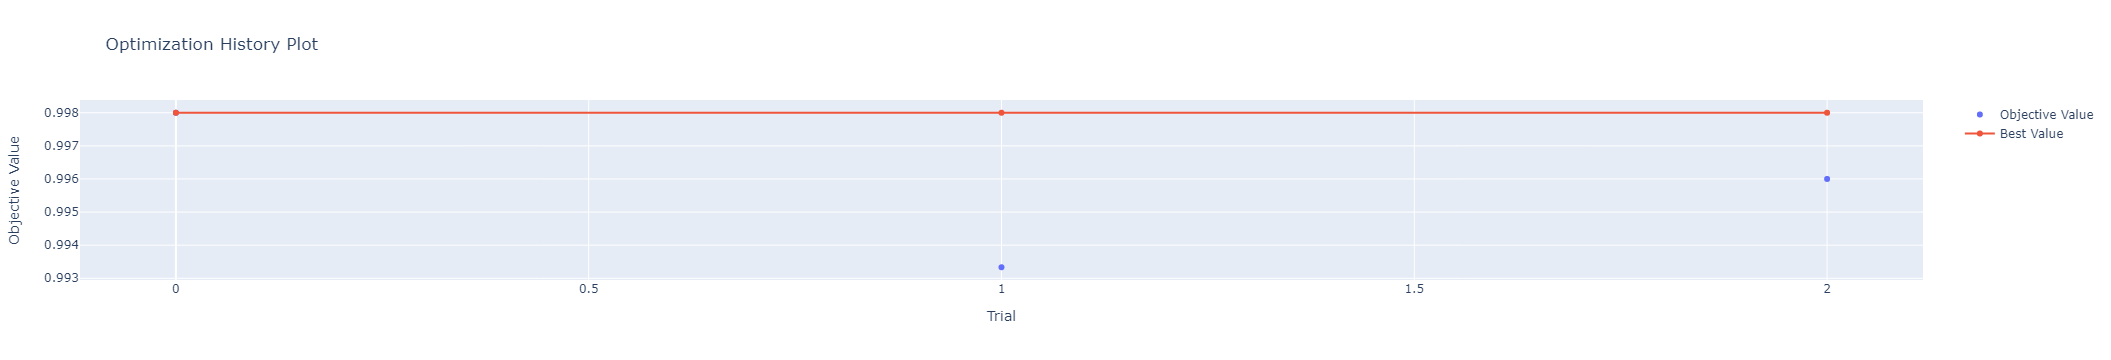

time: 5.7 ms (started: 2022-11-15 14:47:59 +03:00)


In [ ]:
plot_optimization_history(study)

#### Visualization of high-dimensional hyperparameter relations (Визуализация высокоразмерных отношений гиперпараметров)

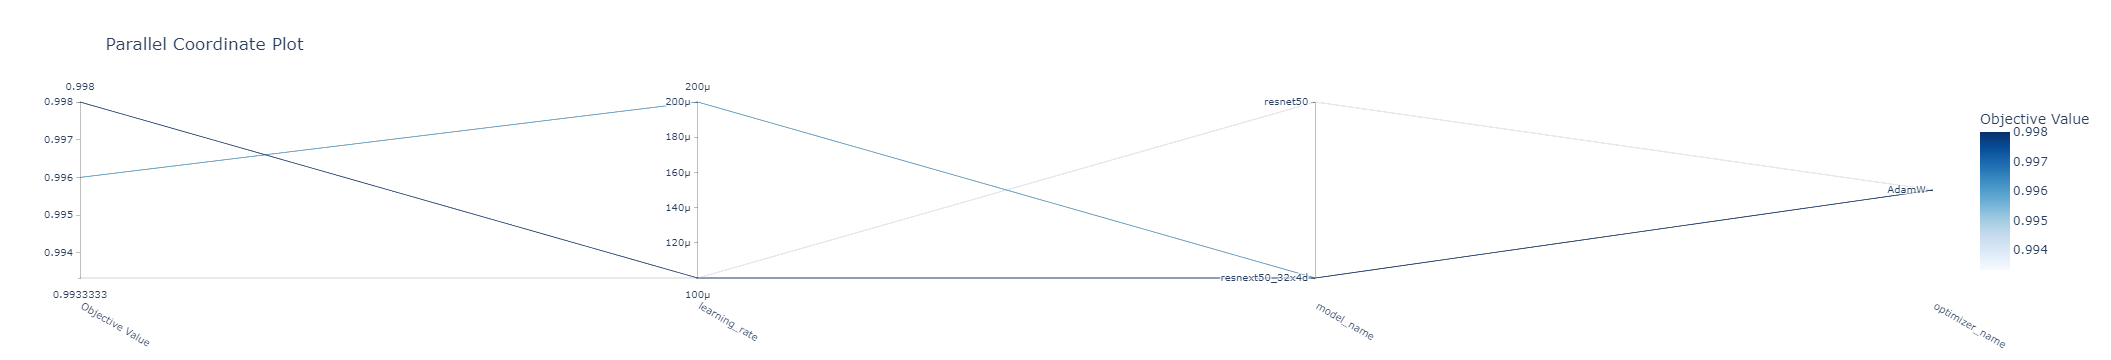

time: 6.92 ms (started: 2022-11-15 14:48:00 +03:00)


In [ ]:
plot_parallel_coordinate(study, params=["model_name", "learning_rate", "optimizer_name"])

#### Visualize the learning curves (Визуализация кривых обучения в ходе испытаний)

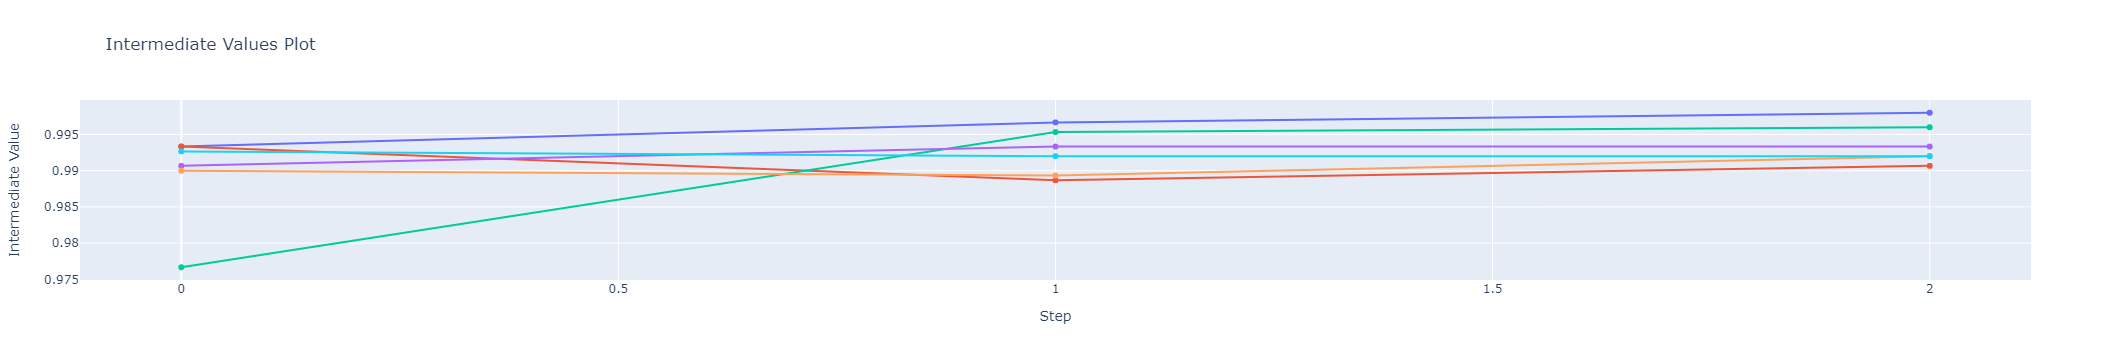

time: 6.39 ms (started: 2022-11-15 14:48:07 +03:00)


In [ ]:
plot_intermediate_values(study)

#### Visualize hyperparameter relationships (Визуализация взаимосвязей гиперпараметров)

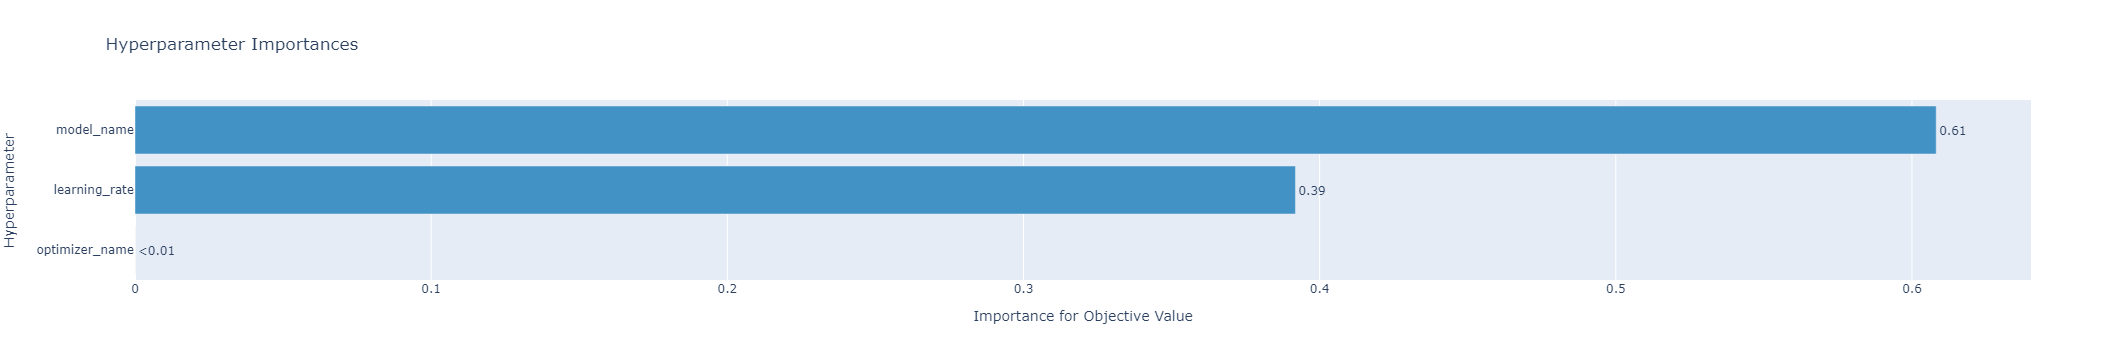

time: 67.1 ms (started: 2022-11-15 14:48:08 +03:00)


In [ ]:
plot_param_importances(study)

Очистим память GPU:

In [ ]:
clear_cuda_cache()

time: 258 ms (started: 2022-11-15 14:48:12 +03:00)


#### Intermediate result (Промежуточный итог)

С помощью алгоритма TPE удалось найти оптимальную комбинацию гиперпараметров на 1 испытании (`Trial 0 finished with value: 0.998 and parameters: {'model_name': 'resnext50_32x4d', 'learning_rate': 0.0001, 'optimizer_name': 'AdamW'}. Best is trial 0 with value: 0.998.`}. Последующие испытания с промежуточными результами меньше, чем медиана промежуточных результатов предыдущих испытаний были отброшенны (`Trial 3 pruned.`,`Trial 4 pruned.`). Это сэкономило нам время и вычислительные рессурсы. На графике "Визуализация связей между гиперпараметрами" хорошо заметно, что алгоритм TPE отдавал большее предпочтение скорости обучения 0.0001.

С ростом количества комбинаций гиперпараметров использование данного алгоритма может дать существенное приемущество, за счёт сокращения количества комбинаций гиперпараметров которые необходимо оценить и досрочного прерывания (обрезки) с последующим отбрасыванием результатов испытаний с низким значением целевой метрики качества модели.

# Проверка качества модели

1. На валидационной части датасета:

Обучим модель с подобранными ранее оптимальными параметрами. Для этого немного переопределим используемую ранее целевую функцию `objective`, она теперь должна вернуть модель (а не ее качество):

In [ ]:
def objective(trial):

    # Гиперпараметры, которые необходимо оптимизировать в рамках испытания "trial"
    params = {
        "model_name": trial.suggest_categorical('model_name',["resnet50", "mobilenet_v3_large", "resnext50_32x4d"]), # Список нейронных сетей (категориальный параметр испытаний)
        "learning_rate": trial.suggest_float('learning_rate', 0.0001, 0.0002, step=0.0001),                          # Скорость обучения (дискретный параметр)
        "optimizer_name": trial.suggest_categorical('optimizer_name',["AdamW"])                                      # Оптимизаторы градиентного спуска
    }
    
    # Получение предварительно обученной модели
    model = get_model(params["model_name"])
    model = model.to(device)
    
    # Определим критерий оптимизации используемый для вычисления потерь между входными и целевыми значениями. 
    # Иными словами функция потерь, используемая в оптимизируемых нейронных сетях.
    # Используем кроссэнтропию, так как классификация многоклассовая
    criterion = nn.CrossEntropyLoss()
    
    # Настроим оптимизатор
    optimizer = getattr(
        torch.optim, 
        params["optimizer_name"])(model.parameters(), lr=params["learning_rate"])
    
    # Обучение модели
    best_model, best_acc = train_model(trial, model, criterion, optimizer, num_epochs=3)
    
    # DEBUG
    print("FUNC train_model, model type :", type(model))
    
    # Возвращает точность (целевое значение) текущего испытания
    return best_model

time: 877 µs (started: 2022-11-15 14:48:32 +03:00)


Проверим текущую лучшую модель, ее параметры должны быть `params={'model_name': 'resnext50_32x4d', 'learning_rate': 0.0001, 'optimizer_name': 'AdamW'}`:

In [ ]:
study.best_trial

FrozenTrial(number=0, values=[0.998], datetime_start=datetime.datetime(2022, 11, 15, 14, 7, 33, 390302), datetime_complete=datetime.datetime(2022, 11, 15, 14, 22, 7, 752614), params={'model_name': 'resnext50_32x4d', 'learning_rate': 0.0001, 'optimizer_name': 'AdamW'}, distributions={'model_name': CategoricalDistribution(choices=('resnet50', 'mobilenet_v3_large', 'resnext50_32x4d')), 'learning_rate': FloatDistribution(high=0.0002, log=False, low=0.0001, step=0.0001), 'optimizer_name': CategoricalDistribution(choices=('AdamW',))}, user_attrs={}, system_attrs={}, intermediate_values={0: 0.9933333333333333, 1: 0.9966666666666666, 2: 0.998}, trial_id=0, state=TrialState.COMPLETE, value=None)

time: 4.64 ms (started: 2022-11-15 14:48:36 +03:00)


Получим обученную с найденными оптимальными гиперпараметрами модель:

In [ ]:
model = objective(study.best_trial)

Epoch 0/2
----------
train Loss: 0.0615 Acc: 0.9828
val Loss: 0.0295 Acc: 0.9920

Epoch 1/2
----------
train Loss: 0.0142 Acc: 0.9961
val Loss: 0.0122 Acc: 0.9987

Epoch 2/2
----------
train Loss: 0.0100 Acc: 0.9972
val Loss: 0.1856 Acc: 0.9827

Training complete in 14m 29s
Best val Acc: 0.998667
FUNC train_model, model type : <class 'torchvision.models.resnet.ResNet'>
FUNC train_model, model type : <class 'torchvision.models.resnet.ResNet'>
time: 14min 29s (started: 2022-11-15 14:48:51 +03:00)


Оценим качество модели на валидационной части датасета:

In [ ]:
true_labels, predicted_labels = predict(model, data_loaders['val'])
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       500

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500

time: 8.01 s (started: 2022-11-15 15:03:58 +03:00)


2. На стророннем экземпляре данных (из интернет):

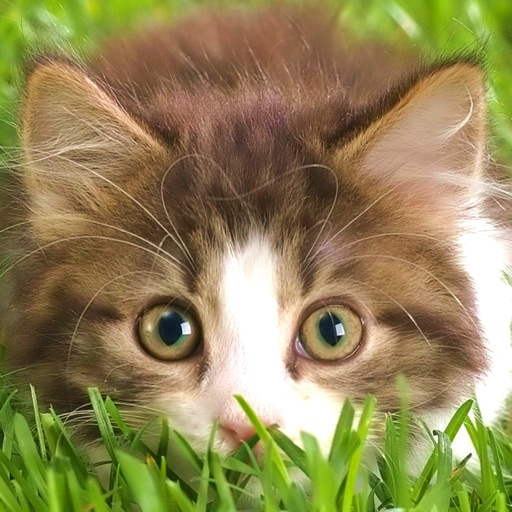

Predicted label for picture: cat
time: 652 ms (started: 2022-11-15 16:00:58 +03:00)


In [ ]:
url = "https://is2-ssl.mzstatic.com/image/thumb/Purple/v4/ef/a9/a2/efa9a23c-73d4-f279-73c7-ad0f8252d56d/source/512x512bb.jpg"

url_image_label(model, url)

# Results (Итоги)

1. Классификация изоображений, как и ожидалось, дала максимальный по качеству результат при примененении "большой модели" ().
2. Применение Optuna позволило снизить время оптимизации гиперпараметров и существенно автоматизировать процесс. Кроме того, с помощью Optuna такж можно строить графики наглядно демонстрирующие процесс оп

# Дополнительные ссылки

Википедия:    
- [Оптимизация гиперпараметров](https://ru.wikipedia.org/wiki/%D0%9E%D0%BF%D1%82%D0%B8%D0%BC%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F_%D0%B3%D0%B8%D0%BF%D0%B5%D1%80%D0%BF%D0%B0%D1%80%D0%B0%D0%BC%D0%B5%D1%82%D1%80%D0%BE%D0%B2)  

Тонкая настройка нейронной сети:    
- [How to modify pre-train PyTorch model for Finetuning and Feature Extraction](https://androidkt.com/modify-pre-train-pytorch-model-for-finetuning-and-feature-extraction/)    
- [Finetuning Torchvision Models](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html)    

Документация Optuna:
- [Optuna: платформа оптимизации гиперпараметров «Определение путем запуска» | SciPy 2019 |](https://www.youtube.com/watch?v=J_aymk4YXhg)
- [optuna.samplers](https://optuna.readthedocs.io/en/stable/reference/samplers/index.html)
- [Efficient Hyperparameter Optimization with Optuna Framework](https://broutonlab.com/blog/efficient-hyperparameter-optimization-with-optuna-framework)
- [Optuna](https://optuna.readthedocs.io/en/stable/index.html)
- [Неплохой пример использования GridSampler](https://github.com/optuna/optuna/issues/3535)
- [Optuna reuse best trial](https://optuna.readthedocs.io/en/stable/tutorial/20_recipes/010_reuse_best_trial.html)
- [Quick Visualization for Hyperparameter Optimization Analysis](https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/005_visualization.html#sphx-glr-tutorial-10-key-features-005-visualization-py)
- [Гиперпараметры: как перестать беспокоиться и начать их оптимизировать](https://habr.com/ru/company/antiplagiat/blog/528384/)
- [Введение в статистическую теорию распознавания образов](https://scask.ru/m_book_inst.php?id=68)
- [Quick Visualization for Hyperparameter Optimization Analysis](https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/005_visualization.html)

Другие темы:
- [Перечень доступных в Pytorch моделей и количество их параметров](https://pytorch.org/vision/stable/models.html#table-of-all-available-classification-weights)

# ЧЕРНОВИКИ

## Стратегия перебора гиперпараметров

В своей работе я буду использовать `RandomSampler` - случайный алгоритм перебора параметров. Чтобы начать оптимизацию нашей **целевой функции (`objective`)**, мы создаем новое **исследование (`study`)**. Целью этого исследования будет максимизация (`direction='maximize'`), так как нам необходимо максимизировать accuracy (и/или количество испытаний, если задан параметр n_trials). Но лучше так не делать, так как иссследование начинает повторно выполнять уже сделанные исследования).

> ПРИМЕАНИЕ:
> n_trials - Количество испытаний для каждого процесса. None означает отсутствие ограничений на количество испытаний. Исследование продолжает создавать испытания, пока количество испытаний не достигнет n_trials, не истечет период тайм-аута, не будет вызвана функция stop() или не будет получен сигнал завершения, такой как SIGTERM или Ctrl+C.

In [ ]:
# Зададим случайный алгоритм перебора параметров.
sampler = optuna.samplers.RandomSampler(seed=17) 

# Создадим исследование 
study = optuna.create_study(
    sampler=sampler,
    direction='maximize')

study.optimize(func=objective, n_trials=6)

print("Best trial: ")
print(study.best_trial)

In [ ]:
print("Best trial: ", study.best_trial.trial_id)
print("Best params:", study.best_trial.params)

## Байесовская оптимизация

Байесовская оптимизация - метод глобальной оптимизации, который заключается в построении стохастической модели функции отображения из значений гиперпараметра в целевую функцию применённую на множестве допустимых значений гиперпараметра (множестве проверки).

В процессе байесовской оптимизации:
1. Cобирается как можно больше информации об оптимизируемой функции, в частности, место оптимума,
2. метод стремиться сбалансировать зондирование (гиперпараметры, для которых изменение наименее достоверно известно) и использование (гиперпараметры, которые, как ожидается, наиболее близки к оптимуму),

На практике баесовская оптимизация демонстрирует более лучший резулььтат с меньшим количеством вычислений (по сравнению с методами поиска по решётке (GreadSearch) и случайным поиском (RandomSearch)) благодаря возможности суждения о качестве экспериментов 
ещё до их выполнения.

In [ ]:
def objective(trial):

    # Гиперпараметры, которые необходимо оптимизировать в рамках испытания "trial"
    params = {
        "model_name": trial.suggest_categorical('model_name',["resnet50", "mobilenet_v3_large", "resnext50_32x4d"]), # Список нейронных сетей (категориальный параметр испытаний)
        "learning_rate": trial.suggest_float('learning_rate', 0.0001, 0.0002, step=0.0001),                          # Скорость обучения (дискретный параметр)
        "optimizer_name": trial.suggest_categorical('optimizer_name',["AdamW"])                                      # Оптимизаторы градиентного спуска
    }
    
    # Получение предварительно обученной модели
    model = get_model(params["model_name"])
    model = model.to(device)
    
    # Определим критерий оптимизации используемый для вычисления потерь между входными и целевыми значениями. 
    # Иными словами функция потерь, используемая в оптимизируемых нейронных сетях.
    # Используем кроссэнтропию, так как классификация многоклассовая
    criterion = nn.CrossEntropyLoss()
    
    # Настроим оптимизатор
    optimizer = getattr(
        torch.optim, 
        params["optimizer_name"])(model.parameters(), lr=params["learning_rate"])
    
    # Обучение модели
    best_model, best_acc = train_model(trial, model, criterion, optimizer, num_epochs=2)
    
    # Возвращает точность (целевое значение) текущего испытания
    return best_acc